In [17]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


In [18]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

In [19]:
def plot_multi(img,start=0,end=100):
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(img[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## data preparation

In [20]:
from pathlib import Path

# this is where the datasets are located
path = Path() / "dataset_cleaned"
print(path)

dataset_cleaned


In [23]:
# your training datasets
# must be cleaned

my_data_num = np.load(path / "digit_data_TrVal_relabeled.npz")
my_data_sym = np.load(path / "op_data_TrVal_relabeled.npz")
my_data_num_test = np.load(path / "digit_data_10_Test_relabeled.npz")
my_data_sym_test = np.load(path / "op_data_10_Test_relabeled.npz")

## visualization

this is just for checking, unnecessary

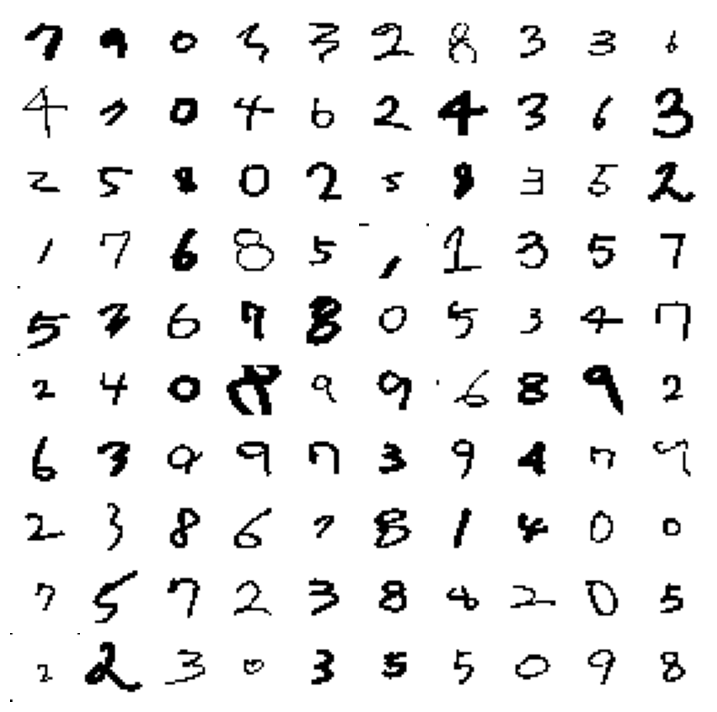

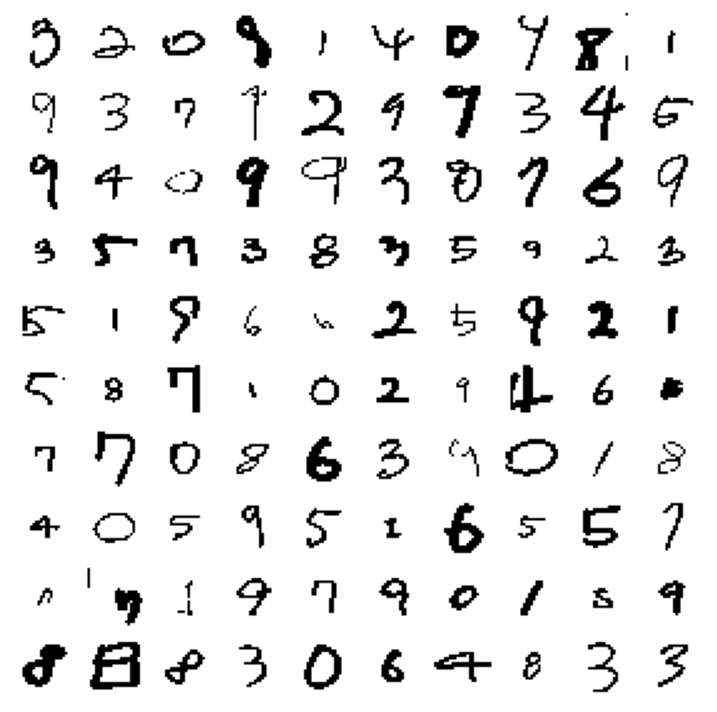

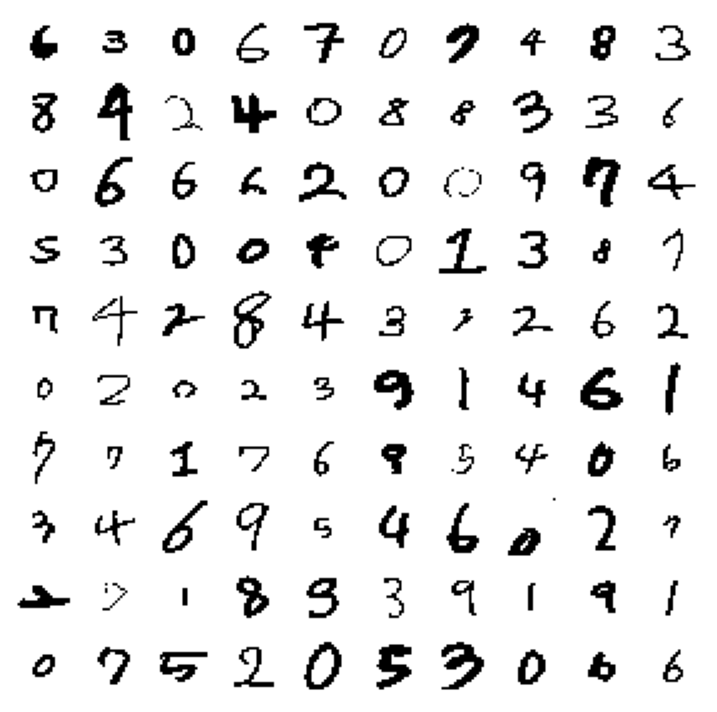

In [24]:
for i in range(3):
    plot_multi(my_data_num["img"],i * 100,i * 100 + 100)

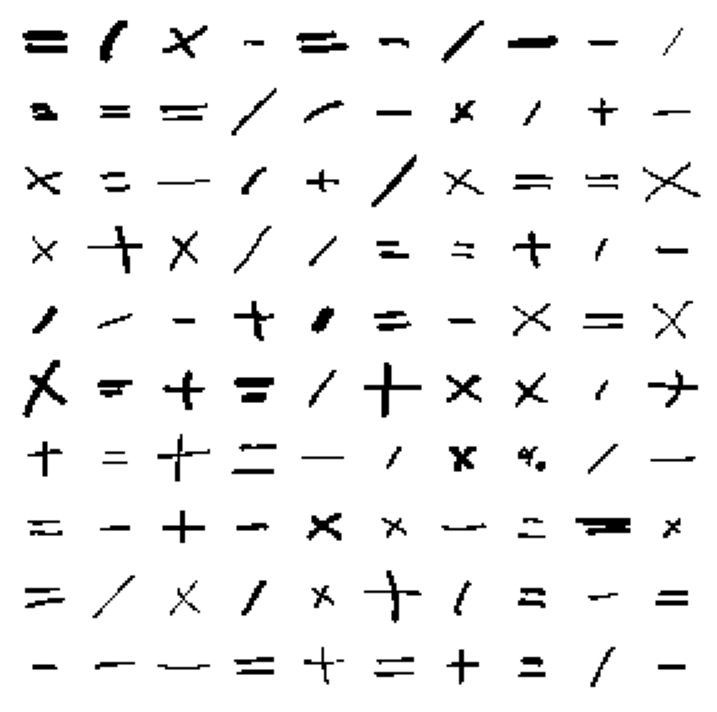

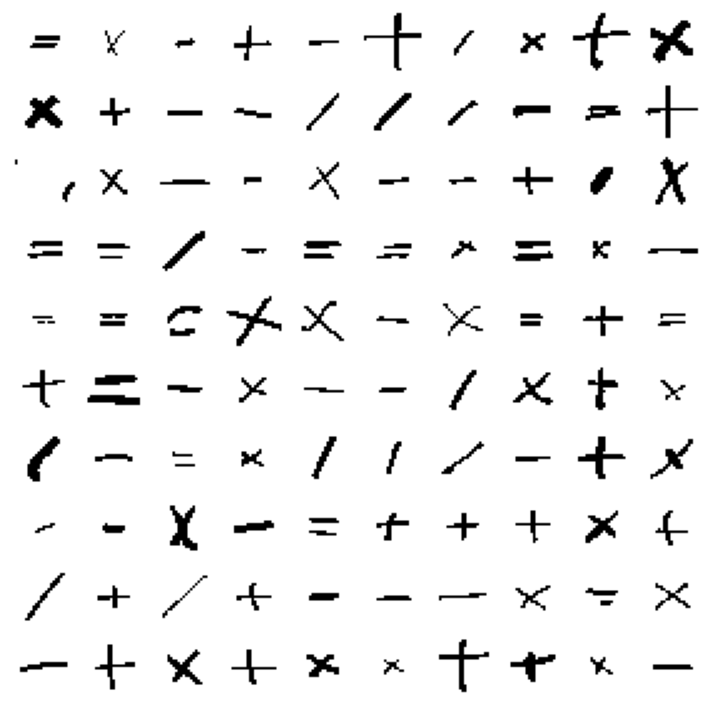

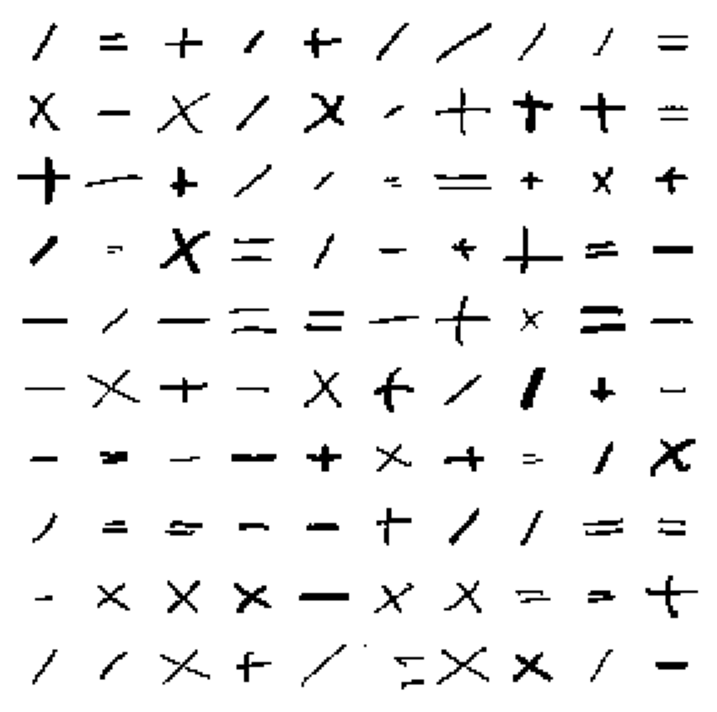

In [25]:
for i in range(3):
    plot_multi(my_data_sym["img"],i * 100,i * 100 + 100)

## preprocessing

1. rebase
2. border deletion
3. dot deletion
4. resize

In [26]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
    
    # print(r_top,r_bot,c_left,c_right)
    
    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r,c),dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start+r_len, c_start:c_start+c_len] = img[r_top:r_bot+1, c_left:c_right+1]
    
    return rebased_data

check the **npzRebase.ipynb** for details

In [27]:
def detect_del_boundary(img, thickness = 4, threshold = 10):
    curr = np.reshape(img,(28,28))
    
    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = threshold
    
    cnt_top = np.count_nonzero(curr[0:t,:])
    cnt_down = np.count_nonzero(curr[28-t:28,:])
    cnt_left = np.count_nonzero(curr[:,0:t])
    cnt_right = np.count_nonzero(curr[:,28-t:28])
    
    flag = False
    
    if cnt_top > threshold_t:
        curr[0:t,:] = 0.
        flag = True
    
    if cnt_down > threshold_t:
        curr[28-t:28,:] = 0.
        flag = True
    
    if cnt_left > threshold_t:
        curr[:,0:t] = 0.
        flag = True
        
    if cnt_right > threshold_t:
        curr[:,28-t:28] = 0.
        flag = True
    
    return rebase_center(curr) if flag is True else curr

check the **npzBorderDel.ipynb** for details

here we will run **rebase_center** if the boundary is deleted

In [28]:
def dfs(r,c,img, visited):
    st = list()
    st.append([r,c])
    
    cord = [[1,1],[1,0],[1,-1],[0,1],[0,-1],[-1,1],[-1,0],[-1,-1]]
    
    dot = list()
    
    while st:
        curr = st.pop()
        
        if visited[curr[0]][curr[1]] == 1.: continue
        
        dot.append(curr)
        visited[curr[0]][curr[1]] = 1.
        
        for n,m in enumerate(cord):
            row = curr[0] + m[0]
            col = curr[1] + m[1]
            
            if 0 <= row < 28 and 0 <= col < 28:
                if img[row][col] != 0. and visited[row][col] == 0.:
                    st.append([row,col])
            
    
    return dot,visited

In [29]:
def d_deletion(img, dot_size = 4):
    
    # to check whether we visited
    isVisited = np.full((28,28),0.)
    
    # dots that needs to be deleted afterwards
    dots = list()
    
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0. and not isVisited[i][j]:
                dot, isVisited = dfs(i,j,img,isVisited)
                
                if len(dot) <= dot_size:
                    dots.extend(dot)
    
    
        for n,m in enumerate(dots):
            img[m[0],m[1]] = 0.
    
    return img

In [30]:
def resize(img,size=18):
    r = 28
    c = 28
    
    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1
    
    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
                
    row_len = r_bot - r_top + 1
    col_len = c_right - c_left + 1
    
    adjusted_img = img[r_top:r_bot+1,c_left:c_right+1]
    
    diff = abs(row_len - col_len)
    
    top_pad = int(diff / 2)
    down_pad = int(diff / 2)
    
    if diff % 2 == 1:
        top_pad += 1
    
    if row_len > col_len:
        adjusted_img = np.pad(adjusted_img, pad_width=((0,0),(top_pad,down_pad)), mode="constant")
            
    else:
        adjusted_img = np.pad(adjusted_img, pad_width=((top_pad,down_pad),(0,0)), mode="constant")         
        

    import cv2
    
    try:
        # using inter_nearest
        resized_img = cv2.resize(adjusted_img, dsize=(size,size),interpolation=0)
    except:
        return img
    
    resized_img = np.pad(resized_img,int((28 - size)/2),mode="constant")
    
    return resized_img

check the **npzThickening.ipynb** for details

In [31]:
def preprocessing(img, rebase=True, b_del=True, d_del=True, re_size=True, one_array=True):
    size = np.shape(img)[0]
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img,(size,r,c))
    
    # rebase
    if rebase:
        print("rebase ongoing")
        
        for x in range(size):
            img_preprocessed[x] = rebase_center(img_preprocessed[x])
        print("done!")
    
    # border deletion
    if b_del:
        print("border deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = detect_del_boundary(img_preprocessed[x])
            
        print("done!")
    
    # dot deletion
    if d_del:
        print("dot deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = d_deletion(img_preprocessed[x])
            
        print("done!")
    
    # resize
    if re_size:
        print("resize ongoing")
        
        for x in range(size):
            img_preprocessed[x] = resize(img_preprocessed[x])
        
        print("done!")
    
    return np.reshape(img_preprocessed,(size,r*c)) if one_array else np.reshape(img_preprocessed,(size,r,c))

In [32]:
my_data_num_img_preprocessed = preprocessing(my_data_num["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


In [33]:
my_data_sym_img_preprocessed = preprocessing(my_data_sym["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


In [34]:
my_data_num_img_preprocessed_test= preprocessing(my_data_num_test["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


In [35]:
my_data_sym_img_preprocessed_test= preprocessing(my_data_sym_test["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


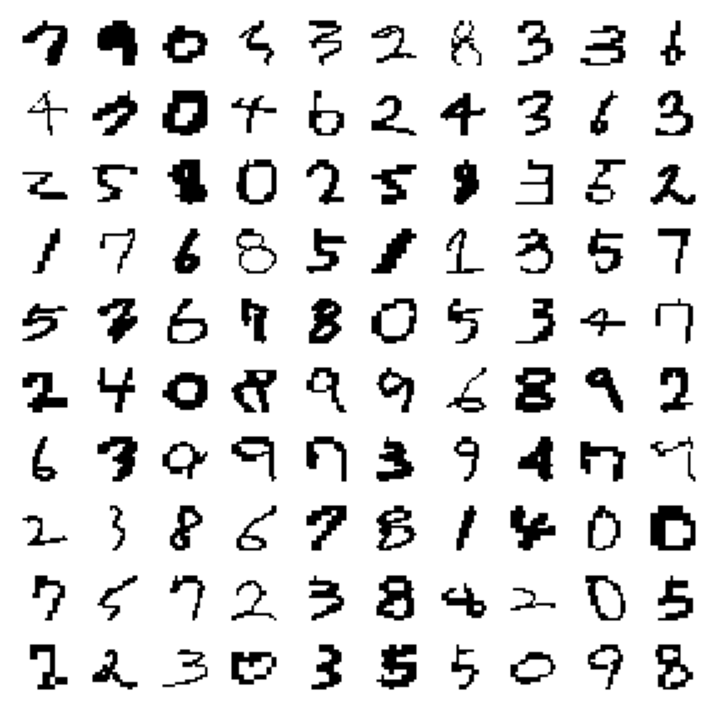

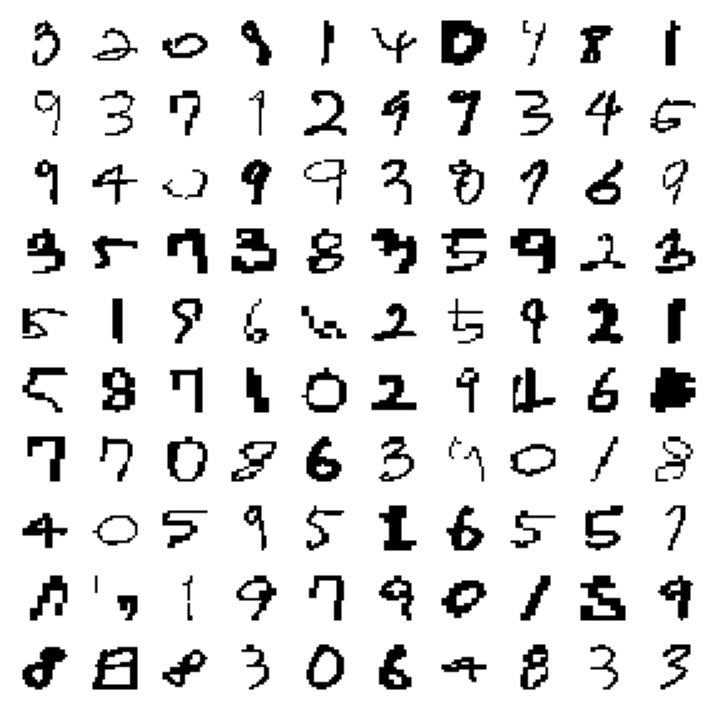

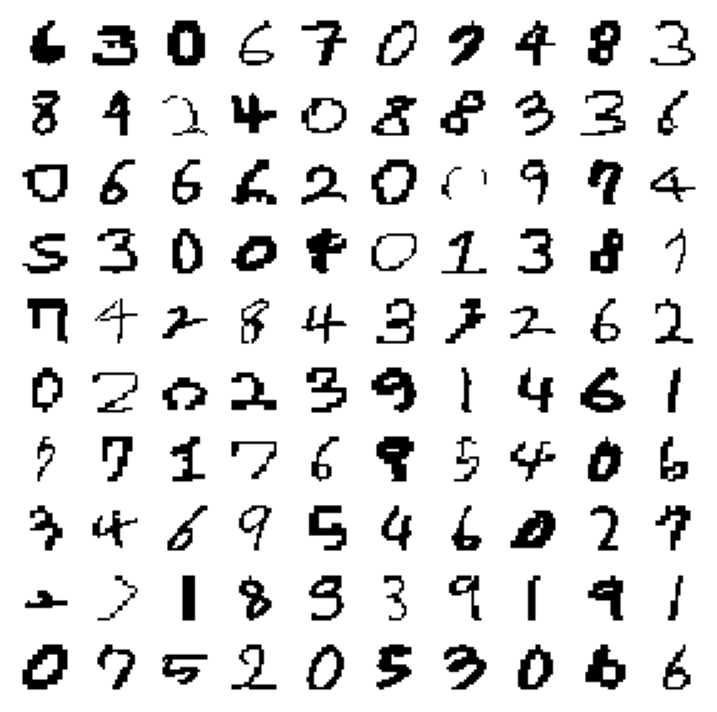

In [36]:
for i in range(3):
    plot_multi(my_data_num_img_preprocessed,i * 100,i * 100 + 100)

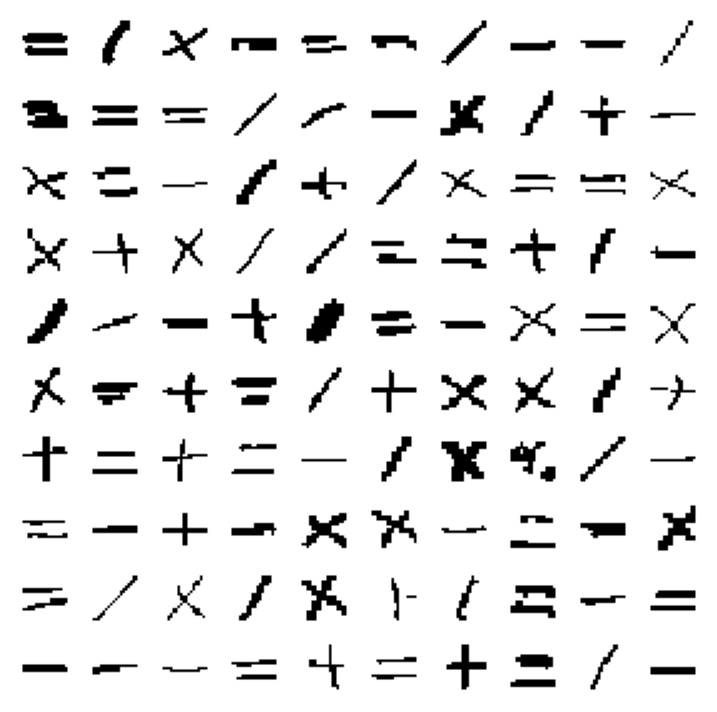

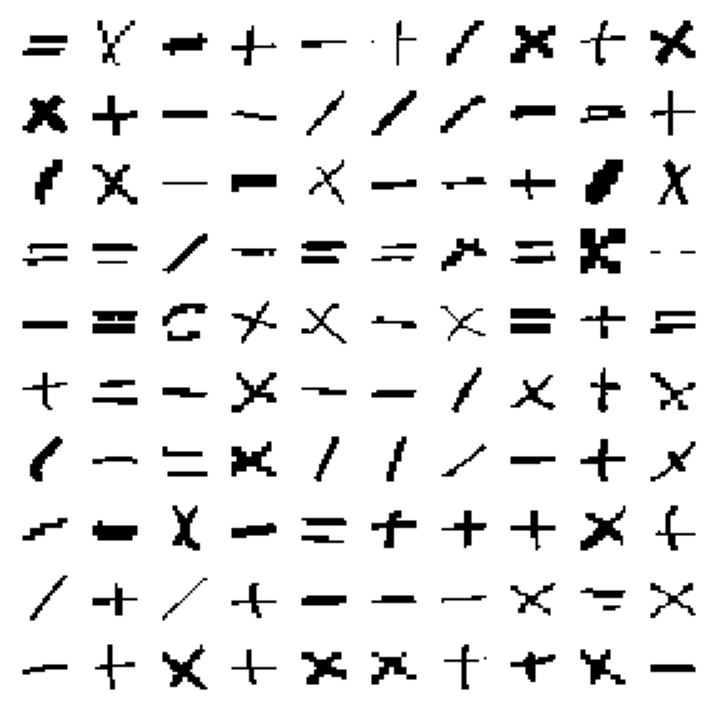

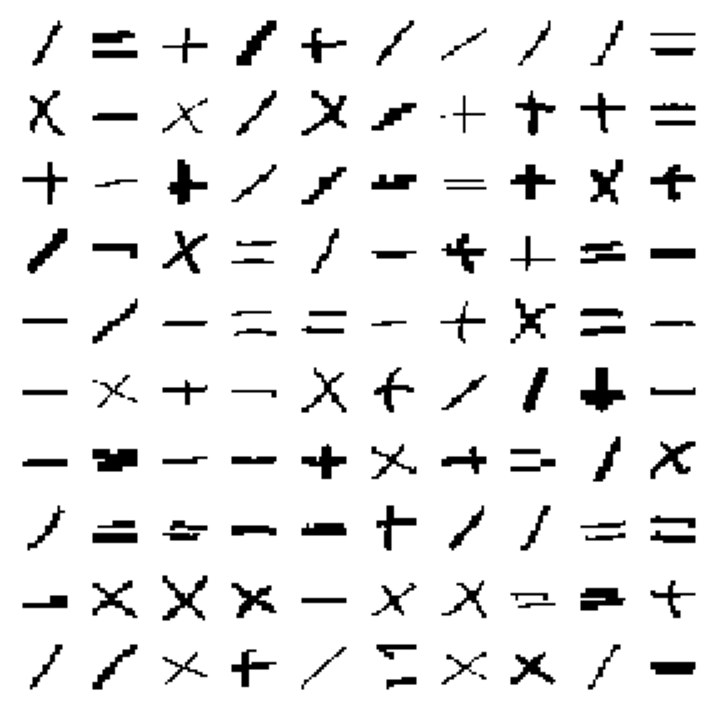

In [37]:
for i in range(3):
    plot_multi(my_data_sym_img_preprocessed,i * 100,i * 100 + 100)

## Making a Combined Data Set


In [48]:
import numpy as np
from sklearn.datasets import fetch_openml

# MNIST 데이터셋 로드
mnist = fetch_openml('mnist_784', version=1)
mnist_images = mnist.data
mnist_labels = mnist.target.astype(np.string_)

# Handmade 데이터셋 이미지와 레이블 추출 
#my_my_data_num_img_preprocessed
my_data_num_labels = my_data_num['label'] 
#my_data_sym_img_preprocessed
my_data_sym_labels = my_data_sym['label']
#my_data_num_img_preprocessed_test
my_data_num_test_labels = my_data_num_test['label']
#my_data_sym_img_preprocessed_test
my_data_sym_test_labels = my_data_sym_test['label']

# 이미지와 레이블을 병합
merged_images_trVal = np.concatenate((mnist_images,np.reshape(my_data_num["img"],(-1,784)),np.reshape(my_data_sym["img"],(-1,784))), axis=0)
merged_images_test = np.concatenate((np.reshape(my_data_num_test["img"],(-1,784)),np.reshape(my_data_sym_test["img"],(-1,784))), axis = 0)
merged_labels_trVal = np.concatenate((mnist_labels, my_data_num_labels, my_data_sym_labels), axis=0)
merged_labels_test = np.concatenate((my_data_num_test_labels, my_data_sym_test_labels), axis=0)

C:\Users\Choi\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [49]:
print(merged_images_trVal.shape, merged_images_test.shape, merged_labels_trVal.shape, merged_labels_test.shape)

(100436, 784) (4327, 784) (100436,) (4327,)


In [50]:
print(merged_images_trVal.dtype, merged_images_test.dtype, merged_labels_trVal.dtype, merged_labels_test.dtype)

float64 float64 <U21 <U21


앞에서부터 10개 이미지 및 레이블:


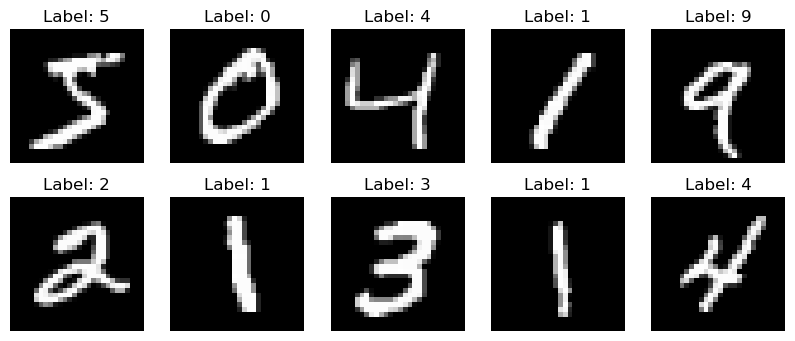

뒤에서부터 10개 이미지 및 레이블:


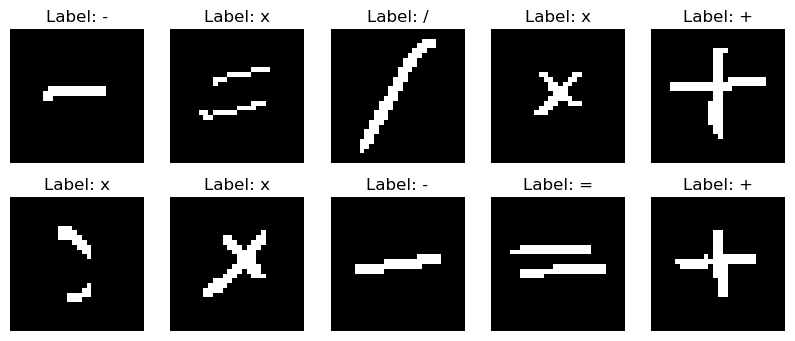

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 앞에서부터 10개 이미지와 레이블 시각화
print("앞에서부터 10개 이미지 및 레이블:")
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(merged_images_trVal[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {merged_labels_trVal[i]}")
    ax.axis('off')
plt.show()

# 뒤에서부터 10개 이미지와 레이블 시각화
print("뒤에서부터 10개 이미지 및 레이블:")
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(merged_images_trVal[-10 + i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {merged_labels_trVal[-10 + i]}")
    ax.axis('off')
plt.show()


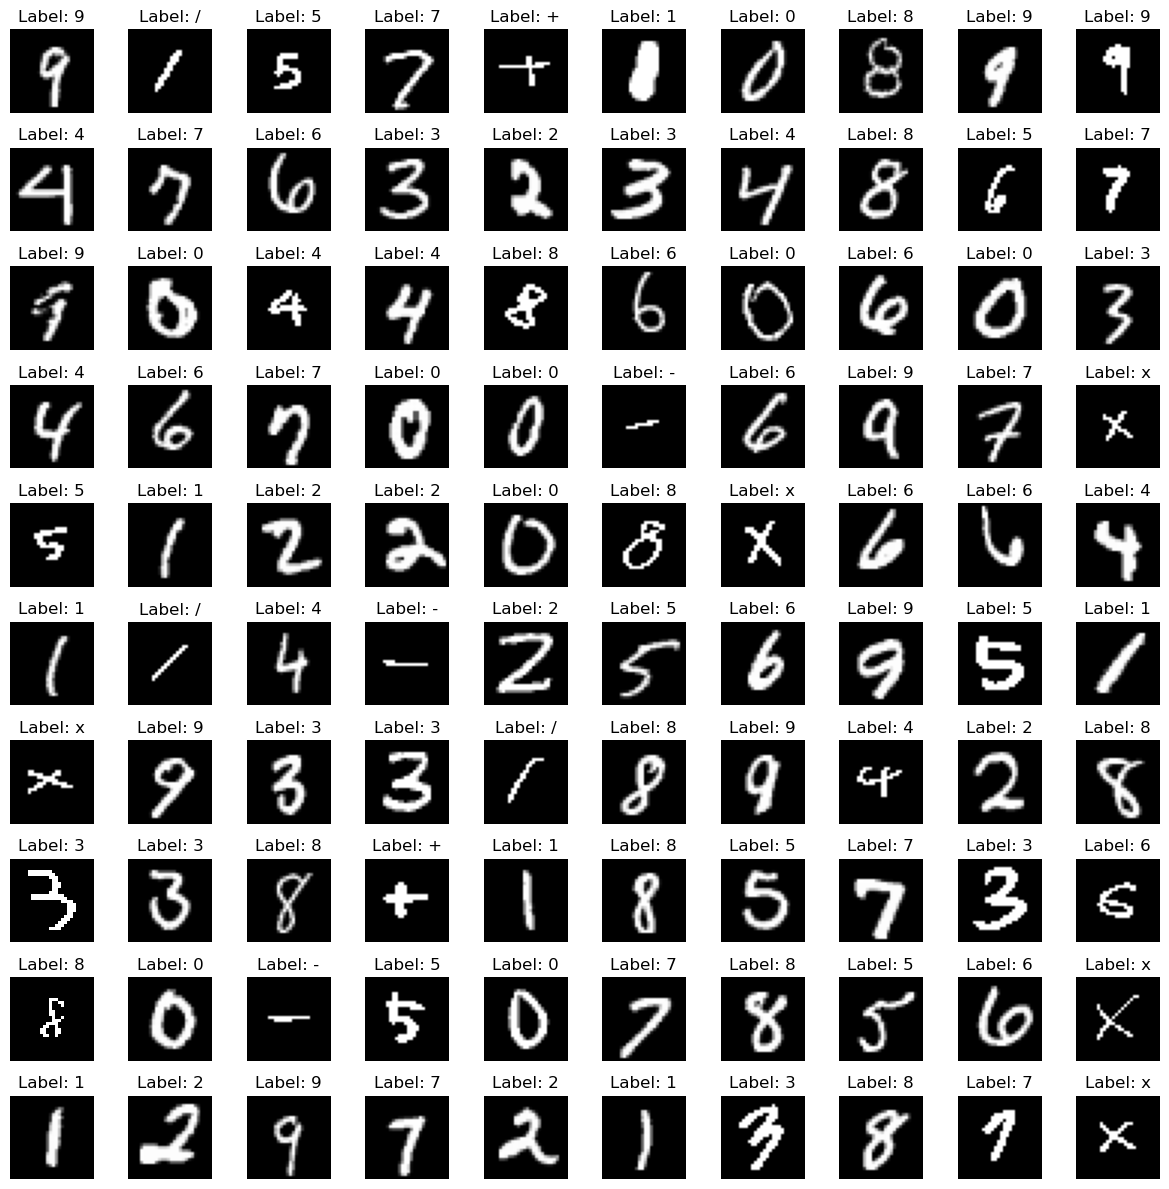

In [52]:
# 무작위로 100개의 인덱스 선택
random_indices = np.random.choice(len(merged_images_trVal), size=100, replace=False)

# 선택된 인덱스에 해당하는 이미지와 레이블 시각화
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    index = random_indices[i]
    image = merged_images_trVal[index].reshape(28, 28)
    label = merged_labels_trVal[index]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [53]:
# 레이블의 종류 확인
label_set = set(merged_labels_trVal)
label_count = len(label_set)

print("레이블의 종류:", label_set)
print("레이블의 개수:", label_count)

레이블의 종류: {'9', '4', '3', '6', '1', '7', '8', '5', '/', '+', '0', '2', '-', '=', 'x'}
레이블의 개수: 15
